In [3]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import spacy
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import confusion_matrix, roc_auc_score

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.columns = ['rating','review']

In [6]:
df = df.iloc[:50000,]

In [7]:
df

,rating,review
0,2,Been going to Dr. Goldberg for over 10 years. ...
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,2,All the food is great here. But the best thing...
4,1,Wing sauce is like water. Pretty much a lot of...
...,...,...
49995,1,whats the DSW stand for in their name? ill tel...
49996,1,"I was not a frequent dsw customer, but had bee..."
49997,1,So I responded via email per request to the CS...
49998,1,"Once again, another fast food place strives fo..."


In [8]:
df.rating.value_counts()

1    26831
2    23169
Name: rating, dtype: int64

## Creating Vocabulary:

In [9]:
vocab = {}

### Initialize:
    we will create a dictionery containing keys 't_2_i','i_2_t','unkToken','unkTokenIdx'
    
    t_2_i stores dictionery of keys as tokens and their id's as values
    i_2_t stores dictionery of keys as id's and their tokens as values
    unkToken is key for <UNK>
    unkToken is key for id of <UNK>

In [10]:
def initializeVocabulary():
    unkToken = '<UNK>'
    vocab['t_2_i'] = {}
    vocab['i_2_t'] = {}
    vocab['unkToken'] = unkToken
    idx = addToken(unkToken)
    vocab['unkTokenIdx']= idx

### Add Token-Id pair:
    we will be adding the token-id pair in the dictionery of vocab.

In [11]:
def addToken(token):
    if token in vocab['t_2_i']:
        idx = vocab['t_2_i'][token]
    else:
        idx = len(vocab['t_2_i'])
        vocab['t_2_i'][token] = idx
        vocab['i_2_t'][idx] = token
    return idx

In [12]:
def addManyTokens(tokens):
    idexs = [addToken(token) for token in tokens]
    return idexs

### Look Up:
    This functions enable us to get the id by giving token and vis-a-vis for token.

In [13]:
def lookUpToken(token):
    if vocab['unkTokenIdx']>=0:
        return vocab['t_2_i'].get(token,vocab['unkTokenIdx'])
    else:
        return vocab['t_2_i'][token]

In [14]:
def lookUpIndex(idx):
    if idx not in vocab['i_2_t']:
        raise KeyError(f'The Index {idx} is not present')
    return vocab['i_2_t'][idx]

### Vocabulary creation:
    
    This function lets us create Vocabulary dictionery , we can either parse pandas Dataframe or Numpy array usually called corpus.

In [15]:
def vocabularyFromDataFrame(df,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    for r in df.review:
        for word in re.split('\W+',r):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count>cutoff:
            addToken(word)
        

In [16]:
def vocabularyFromCorpus(corpus,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    for doc in corpus:
        for word in re.split('\W+',doc):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count>cutoff:
            addToken(word)
        

In [17]:
x = np.asarray(df['review'])
vocabularyFromCorpus(x)

In [18]:
vocabularyFromDataFrame(df)

### Onehot Encoding:
    Based on the total words present in our vocabulary we will be OneHotEncoding the document present in corpus.
    
    Token is the document we want to OneHot Encode and 'N' is the total number of words present in vocabulary.

In [19]:
def OneHotVector(token,N):
    onehot = np.zeros((N,1))
    onehot[lookUpToken(token)] = 1
    return onehot

In [20]:
# example
N = len(vocab['t_2_i'])
token = 'now'
Onehot = OneHotVector(token,N)

In [21]:
lookUpToken('now')

38

In [22]:
Onehot[507]

array([0.])

### Feature Computation:
    
    The feature computation is responsible for aggregating all the onehot encoded vectors of words present in the document into single column.

In [23]:
# time complexity is higher, but useful for giving the description of the function.
def computeFeatures(doc,N):
    isfirst = True
    for token in doc:
        onehot = OneHotVector(token,N)
        if isfirst:
            xF=onehot
            isfirst = False
        else:
            xF = np.hstack((xF,onehot))
    return np.mean(xF,axis=1).reshape(-1,1)

In [24]:
# less time complexity.
def computeFeature_fast(doc,N):
    fv  = np.zeros(N)
    numTokens=0
    for token in doc:
        fv[lookUpToken(token)] += 1
        numTokens += 1
    return fv/numTokens

### Feature Matrix:
    
    This function helps us create a Function Matrix of all documents present in our dataset.
    
    It will return a Feature Matrix of one hot encoded rows respectively to the document present in the dataset.

In [25]:
def corpusToFeaturMatrix(Corpus,N):
    isfirst = True
    for doc in Corpus:
        fv = computeFeatures(doc,N)
        if isfirst:
            fM = fv
            isfirst=False
        else:
            fM=np.hstack((fM,fv))
    return fM.T

In [26]:
def corpusTofeatureMatrix_fast(corpus,N):
    fM = np.zeros((N,len(corpus)))
    i=0
    for doc in corpus:
        fM[:,i] = computeFeature_fast(doc,N)
        i+=1
        
    return fM.T

In [27]:
# example
fv = computeFeatures(x[0],N)

In [28]:
fv.shape

(9758, 1)

In [29]:
fv

array([[0.22424242],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

# Data Splitting :

In [30]:
x = np.array(df.review)
y = np.asarray(df.rating)
print(x.shape, y.shape)

(50000,) (50000,)


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

# Initialising Vocabulary:
    Note: Here we will assume the words present in our train dataset is our whole universe of words present.

In [33]:
vocabularyFromCorpus(x_train)

## Creating Corpus Matrices:

In [34]:
N = len(vocab['t_2_i'])
xtrain_fM = corpusTofeatureMatrix_fast(x_train,N)
xtest_fM = corpusTofeatureMatrix_fast(x_test,N)

In [35]:
# creating dataframe from the feature matrix
dftrain = pd.DataFrame(xtrain_fM)
dftest = pd.DataFrame(xtest_fM)

# Model Training:
     here we will employing the ML Model Logistic Regression, not particularly the ML Model with the best accuracy score,
     
     but usefull for understanding the process of classification.

In [36]:
m = lr().fit(xtrain_fM,y_train)

In [37]:
df.rating.value_counts()

1    26831
2    23169
Name: rating, dtype: int64

In [38]:
y_pred_train = m.predict(xtrain_fM)
roc_auc_score(y_train,y_pred_train)

0.6465044942719423

<Axes: >

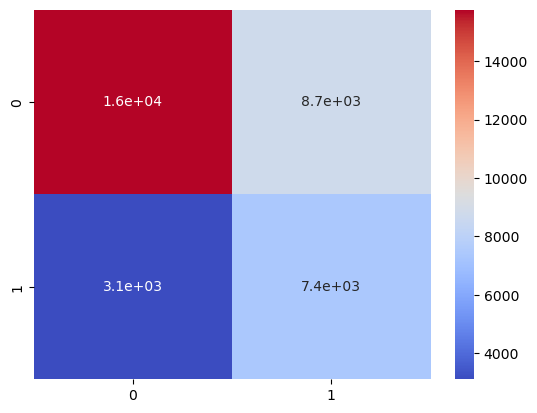

In [39]:
mat_train = confusion_matrix(y_train,y_pred_train)
sns.heatmap(mat_train.T,cmap='coolwarm',annot=True)

In [40]:
y_pred_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [41]:
y_pred_test = m.predict(xtest_fM)
roc_auc_score(y_test,y_pred_test)

0.6496306510914764

<Axes: >

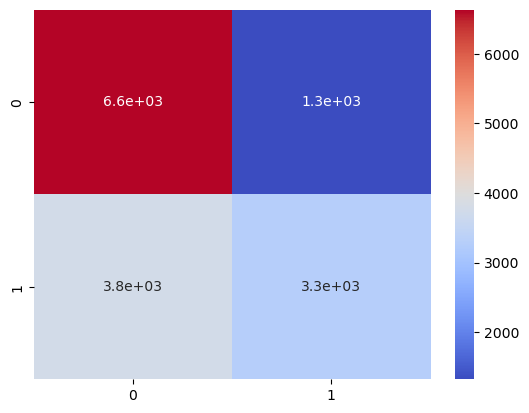

In [42]:
mat_test = confusion_matrix(y_test,y_pred_test)
sns.heatmap(mat_test,cmap='coolwarm',annot=True)